##Caricamento dataset

In [ ]:
# Installazione della libreria torchmetrics per metriche di valutazione
!pip install torchmetrics
!pip install astroNN torch

from astroNN.datasets import load_galaxy10
# Importazione delle librerie principali
import numpy as np
import matplotlib.pyplot as plt
import h5py  # Per gestire file HDF5

# Librerie PyTorch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset,TensorDataset
from torchvision import transforms  # Per trasformazioni delle immagini
from torchmetrics.functional import structural_similarity_index_measure  # Per metriche

# Controllo se la GPU è disponibile e imposto il device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Caricamento del dataset usando astroNN
images, _ = load_galaxy10()  # Carica solo le immagini, ignora le etichette

# Definizione del dataset personalizzato con ridimensionamento e conversione in bianco e nero per il downsample
class Galaxy10Dataset(Dataset):
    def __init__(self, images, target_size=(28, 28)):
        """
        Inizializza il dataset con le immagini e definisce una trasformazione
        per ridimensionare le immagini a target_size e convertire in scala di grigi solo per il downsample.
        """
        self.images = images

        # Definisce la trasformazione per ridimensionare le immagini a target_size e convertirle in scala di grigi
        self.transform_to_gray = transforms.Compose([
            transforms.ToPILImage(),        # Converte da Tensor a PIL Image
            transforms.Resize(target_size), # Ridimensiona le immagini a target_size
            transforms.Grayscale(),         # Converte in scala di grigi
            transforms.ToTensor()           # Converte di nuovo a Tensor
        ])

    def __len__(self):
        """Restituisce la lunghezza del dataset."""
        return len(self.images)

    def __getitem__(self, idx):
        """
        Restituisce sia l'immagine originale a colori (target) che la versione downsampled in bianco e nero.
        L'immagine originale è normalizzata e ridimensionata.
        """
        # Normalizza l'immagine originale a colori tra 0 e 1 e la converte in tensor PyTorch
        original_image = self.images[idx] / 255.0  # Normalizza l'immagine tra 0 e 1
        original_image = torch.tensor(original_image, dtype=torch.float32).permute(2, 0, 1)  # Cambia l'ordine dei canali

        # Crea l'immagine downsampled in bianco e nero applicando la trasformazione
        downsampled_image = self.transform_to_gray(original_image.permute(1, 2, 0).numpy())  # Riordina i canali per PIL

        # Restituisce sia l'immagine originale a colori (target) che quella ridimensionata in bianco e nero
        return downsampled_image, original_image

# Creazione del DataLoader direttamente dalle immagini caricate
galaxy_dataset = Galaxy10Dataset(images)
dataloader = DataLoader(galaxy_dataset, batch_size=32, shuffle=True)


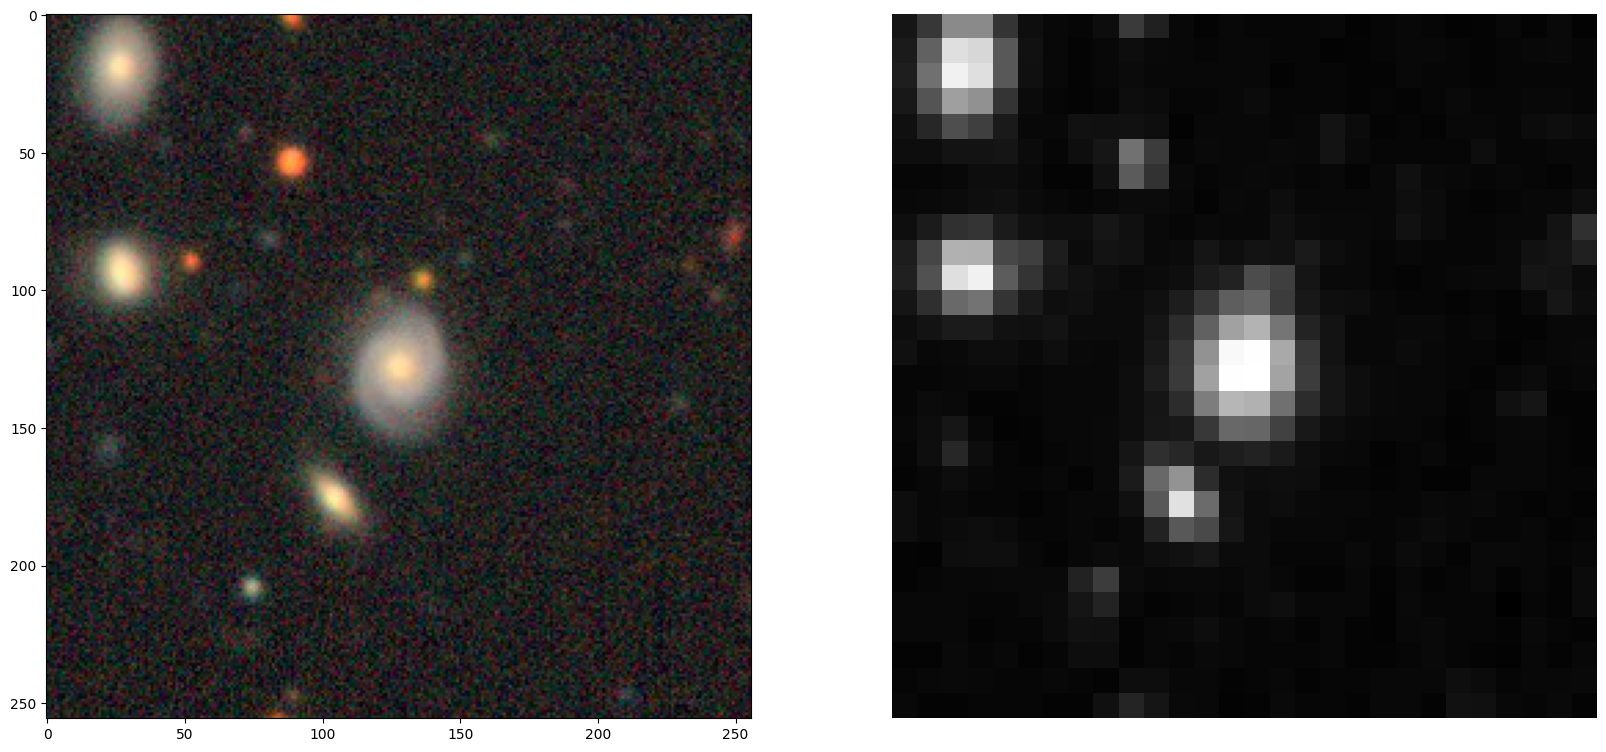

torch.Size([32, 3, 256, 256])

In [ ]:
initial,target= next(iter(dataloader))
fig, axs = plt.subplots(1, 2, figsize=(20, 20))
axs[0].imshow(np.transpose(target[12].cpu().detach().numpy(), (1, 2, 0)),cmap='gray')
axs[1].imshow(np.transpose(initial[12].cpu().detach().numpy(), (1, 2, 0)),cmap='gray')
plt.axis('off')
plt.show()
target.shape

##AE classico

###Definizione

In [ ]:
import torch.nn.functional as F
import torch
import numpy as np
!pip install torchmetrics
# import delle librerie
import numpy as np
import matplotlib.pyplot as plt

# pytorch
import torch
import torchvision
from torch import nn
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchmetrics.functional import structural_similarity_index_measure
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Decoder_esterno(nn.Module):
    def __init__(self, hidden_channels=64):
        super().__init__()

        # Layer fully connected per passare da 28x28 a una dimensione adatta per la prima deconvoluzione
        self.fc = nn.Linear(in_features=1*28*28, out_features=hidden_channels*4*16*16)

        # Primo blocco di deconvoluzione: 16x16 -> 32x32
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_channels*4, out_channels=hidden_channels*2, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.LeakyReLU(negative_slope=0.01)
        )

        # Secondo blocco di deconvoluzione: 32x32 -> 64x64
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_channels*2, out_channels=hidden_channels, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.LeakyReLU(negative_slope=0.01)
        )

        # Terzo blocco di deconvoluzione: 64x64 -> 128x128
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=4, stride=2, padding=1),  # 64x64 -> 128x128
            nn.LeakyReLU(negative_slope=0.01)
        )

        # Quarto blocco di deconvoluzione: 128x128 -> 256x256
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_channels, out_channels=3, kernel_size=4, stride=2, padding=1)  # 128x128 -> 256x256
        )

        self.output_activation = nn.Sigmoid()  # Per riportare l'output nell'intervallo [0, 1]

    def forward(self, z):
        # Inizialmente z è di dimensioni (batch_size, 1, 28, 28), quindi lo flattiamo
        z = z.view(z.size(0), -1)  # Flatten (batch_size, 1*28*28)

        # Passiamo attraverso il fully connected layer per espandere la dimensione
        z = self.fc(z)

        # Reshape per essere pronto alla deconvoluzione: (batch_size, hidden_channels*4, 16, 16)
        z = z.view(z.size(0), 64*4, 16, 16)

        # Passiamo attraverso i blocchi di deconvoluzione
        z = self.deconv1(z)  # 16x16 -> 32x32
        z = self.deconv2(z)  # 32x32 -> 64x64
        z = self.deconv3(z)  # 64x64 -> 128x128
        z = self.deconv4(z)  # 128x128 -> 256x256

        # Applichiamo la funzione di attivazione sigmoid per mappare i valori nell'intervallo [0, 1]
        z = self.output_activation(z)

        return z


###Training

In [ ]:
#TRAINING CON MONITORAGGIO IMMAGINI
def imshow(img, title=None):
    # Convert tensor to numpy array and denormalize if needed
    #img = img / 2 + 0.5  # Assuming images are normalized to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

class SSIMLoss(nn.Module):
    def __init__(self):
        super(SSIMLoss, self).__init__()

    def forward(self, img1, img2):
        # 1 - SSIM per usarlo come una funzione di perdita
        return 1 - structural_similarity_index_measure(img1, img2)



def train(decoder, dataloader, criterion, optimizer, num_epochs, device):
  decoder.train()
  for epoch in range(num_epochs):
    epoch_loss = 0
    for initial,target in dataloader:
        initial = initial.to(device)
        target=target.to(device)
        pred =decoder(initial)
        loss =criterion(target, pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * initial.size(0)

    avg_loss = epoch_loss / len(dataloader.dataset)
    print(f'Epoca [{epoch+1}/{num_epochs}], Perdita: {avg_loss:.4f}')

    # Visualizza immagini ultima epoche
    if (epoch + 1) % 2 == 0:
        # Mostra alcune immagini originali
        img_grid = torchvision.utils.make_grid(initial.cpu().detach(), nrow=8, padding=2, normalize=True)
        imshow(img_grid, title="Originali")

        # Mostra le immagini ricostruite
        output_grid = torchvision.utils.make_grid(pred.cpu().detach(), nrow=8, padding=2, normalize=True)
        imshow(output_grid, title="Ricostruite")


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.


Epoca [1/20], Perdita: 0.7086
Epoca [2/20], Perdita: 0.6911


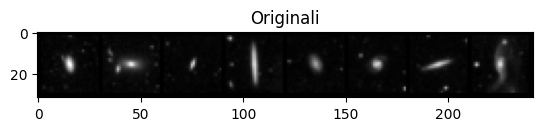

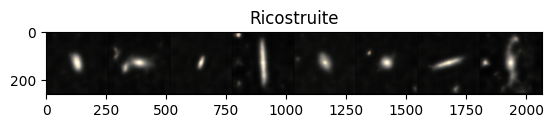

Epoca [3/20], Perdita: 0.6867
Epoca [4/20], Perdita: 0.6842


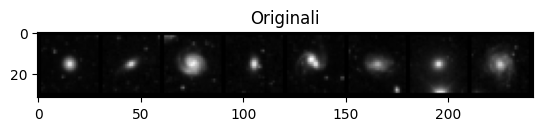

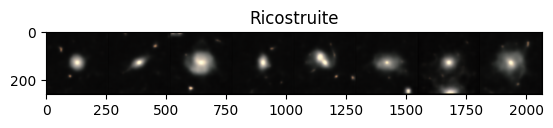

Epoca [5/20], Perdita: 0.6828
Epoca [6/20], Perdita: 0.6818


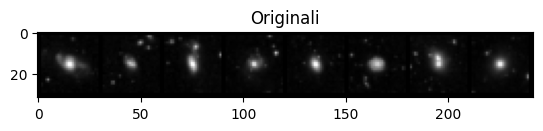

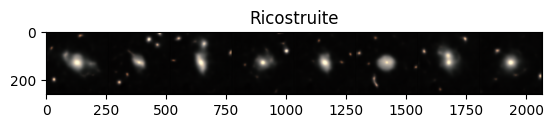

Epoca [7/20], Perdita: 0.6810
Epoca [8/20], Perdita: 0.6803


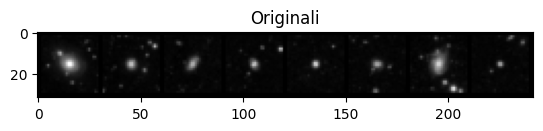

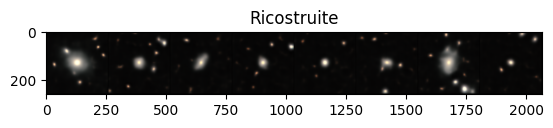

Epoca [9/20], Perdita: 0.6796
Epoca [10/20], Perdita: 0.6791


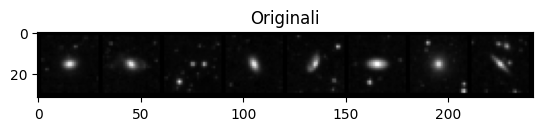

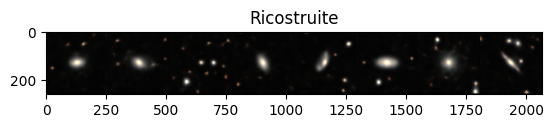

Epoca [11/20], Perdita: 0.6787
Epoca [12/20], Perdita: 0.6783


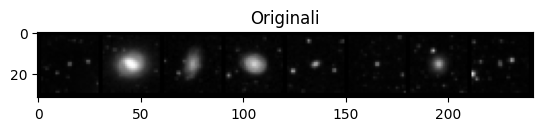

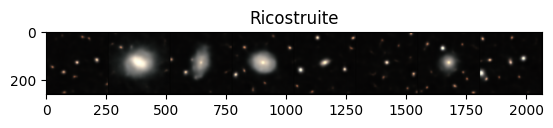

Epoca [13/20], Perdita: 0.6779
Epoca [14/20], Perdita: 0.6775


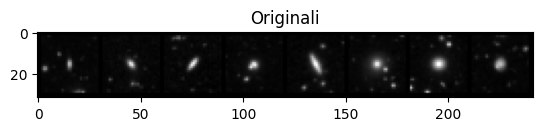

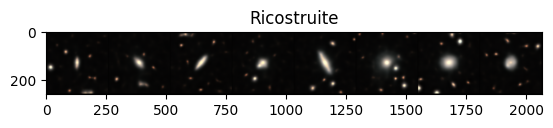

Epoca [15/20], Perdita: 0.6772
Epoca [16/20], Perdita: 0.6770


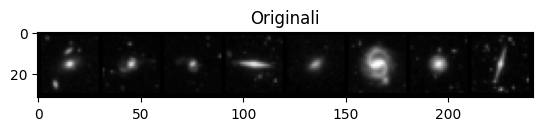

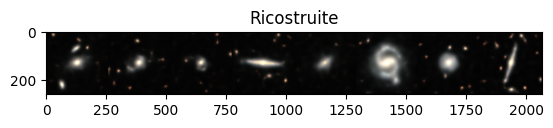

Epoca [17/20], Perdita: 0.6767
Epoca [18/20], Perdita: 0.6764


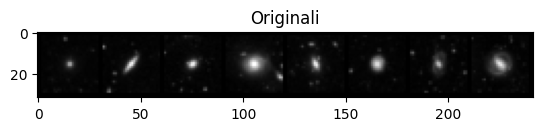

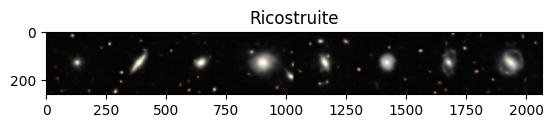

Epoca [19/20], Perdita: 0.6762
Epoca [20/20], Perdita: 0.6759


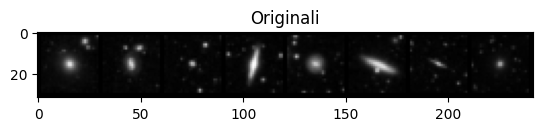

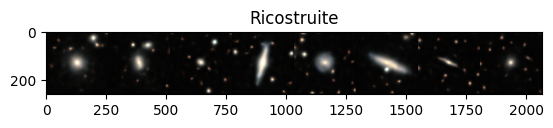

In [ ]:
batch_size = 32
learning_rate = 3e-4
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
decoder = Decoder_esterno().to(device)  # Trasferisce il modello al device
criterion = SSIMLoss()
optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
train(decoder, dataloader, criterion, optimizer, num_epochs, device)

####Salvataggio AE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Poi salva il file nel percorso di Google Drive
torch.save(decoder.state_dict(), '/content/drive/MyDrive/Decoder_esterno/Decoder_esterno_colori.pth')

#Caricamento AE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

decoder=Decoder_esterno()
decoder.load_state_dict(torch.load('/content/drive/MyDrive/Decoder_esterno/Decoder_esterno_colori.pth'))  # Carica i pesi salvati
decoder.to(device)  # Sposta il modello sul dispositivo corretto, se necessario (CPU o GPU)
decoder.eval()  # Passa il modello in modalità di valutazione

##Esempio decoder

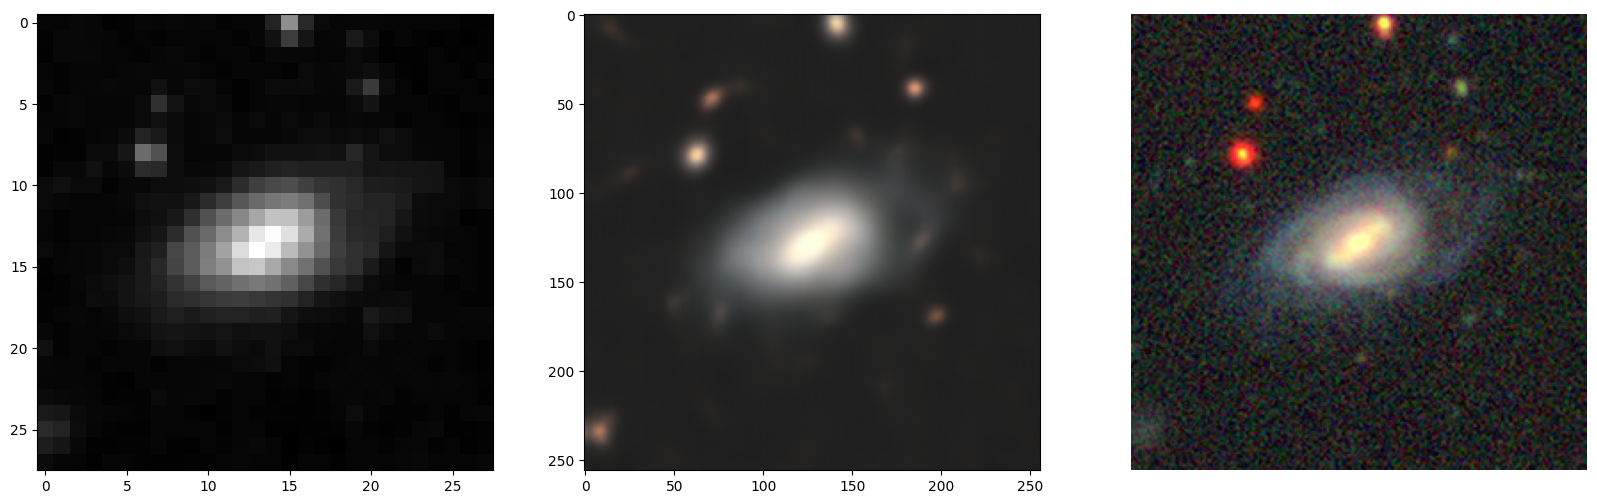

torch.Size([32, 3, 256, 256])

In [ ]:
from re import A
import warnings
decoder.eval()
warnings.filterwarnings('ignore')
initial,target= next(iter(dataloader))
a=17
with torch.no_grad():
  rec=decoder(initial[a].to(device))

fig, axs = plt.subplots(1, 3, figsize=(20, 20))
axs[0].imshow(np.transpose(initial[a].cpu().detach().numpy(), (1, 2, 0)),cmap='gray')
axs[1].imshow(np.transpose(rec.cpu().detach().squeeze().numpy(), (1, 2, 0)),cmap='gray')
axs[2].imshow(np.transpose(target[a].cpu().detach().numpy(), (1, 2, 0)),cmap='gray')


plt.axis('off')
plt.show()
target.shape

###Esempio su puro rumore normalizzato

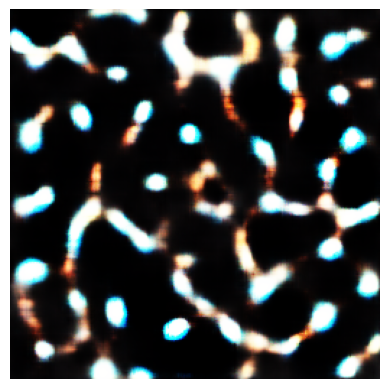

In [ ]:
noise=np.random.normal(0,1,size=(1,28,28))
with torch.no_grad():
    # Convert noise to a PyTorch tensor and move to the appropriate device
    noise_tensor = torch.tensor(noise, dtype=torch.float32).to(device)
    # Pass the normalized noise to the decoder
    img = decoder(noise_tensor)
    # Display the image
    plt.imshow(img.cpu().detach().numpy().squeeze(0).transpose(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()